# Super Resolution GANs: Aumentando a Resolução de Imagens com IA

A super-resolução é o processo de aumentar a resolução de uma imagem, permitindo que detalhes adicionais sejam visíveis. As Redes Neurais Generativas Adversariais (GANs) têm sido amplamente utilizadas para abordar esse problema e são conhecidas como Super Resolution GANs (SRGANs). Esta técnica é especialmente útil quando queremos melhorar a qualidade visual de imagens de baixa resolução, como imagens antigas ou capturas de câmeras de baixa qualidade.
Como as SRGANs funcionam?

As SRGANs operam com base no conceito de GANs, que consiste em duas redes principais:

* **Gerador (Generator)**: Esta rede é responsável por criar imagens de alta resolução a partir de imagens de baixa resolução de entrada. O gerador tenta aprender a mapear imagens de baixa resolução para imagens de alta resolução, de modo que a qualidade das imagens geradas seja alta o suficiente para parecerem naturais.

* **Discriminador (Discriminator)**: O discriminador é uma rede que atua como um "juiz" e avalia se uma imagem de alta resolução é real (ou seja, vinda de um conjunto de dados real) ou falsa (gerada pelo gerador). Ele aprende a distinguir entre imagens reais e geradas.

Treinamento da SRGAN

O treinamento de uma SRGAN envolve um processo de competição entre o gerador e o discriminador:

1. O gerador tenta gerar imagens de alta resolução a partir de imagens de baixa resolução, passando-as pelo discriminador.

2. O discriminador tenta distinguir entre imagens de alta resolução reais e imagens geradas pelo gerador.

3. Durante o treinamento, o gerador e o discriminador são aprimorados em direções opostas: o gerador tenta enganar o discriminador, enquanto o discriminador tenta se tornar mais eficaz na detecção de imagens falsas.

Aplicação de SRGANs

As SRGANs têm várias aplicações, incluindo:

* Melhoria de imagens antigas: Elas podem ser usadas para aumentar a resolução de fotos antigas e restaurar sua qualidade visual.

* Aprimoramento de imagens de vigilância: SRGANs podem melhorar a qualidade de imagens de vigilância de baixa resolução, tornando detalhes importantes mais visíveis.

* Geração de conteúdo de alta resolução: Elas são usadas em computação gráfica para criar texturas de alta resolução e detalhes em jogos, filmes e animações.

In [ ]:
!pip install tqdm scikit-image

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"
!chmod 600 /content/kaggle.json


!kaggle datasets download -d psvenom/qrimagesaugmented
!unzip /content/qrimagesaugmented.zip -d /content/kaggle/

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: /content/kaggle/content/qr_dataset/5455-v1.png  
  inflating: /content/kaggle/content/qr_dataset/5455-v2.png  
  inflating: /content/kaggle/content/qr_dataset/5455-v3.png  
  inflating: /content/kaggle/content/qr_dataset/5455-v4.png  
  inflating: /content/kaggle/content/qr_dataset/5456-v1.png  
  inflating: /content/kaggle/content/qr_dataset/5456-v2.png  
  inflating: /content/kaggle/content/qr_dataset/5456-v3.png  
  inflating: /content/kaggle/content/qr_dataset/5456-v4.png  
  inflating: /content/kaggle/content/qr_dataset/5457-v1.png  
  inflating: /content/kaggle/content/qr_dataset/5457-v2.png  
  inflating: /content/kaggle/content/qr_dataset/5457-v3.png  
  inflating: /content/kaggle/content/qr_dataset/5457-v4.png  
  inflating: /content/kaggle/content/qr_dataset/5464-v1.png  
  inflating: /content/kaggle/content/qr_dataset/5464-v2.png  
  inflating: /content/kaggle/content/qr_dataset/5464-v3.png  
  inflating

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras import layers, Model
from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tensorflow.keras.applications.vgg19 import VGG19


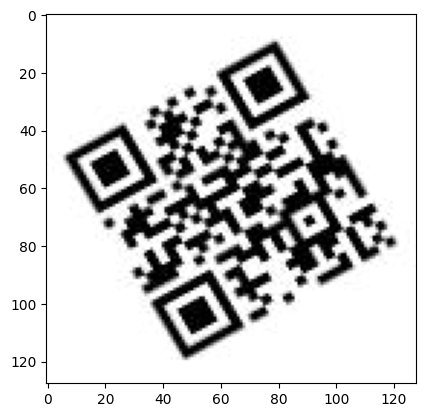

In [ ]:

datadir = '/content/kaggle/content/qr_augmented'
for img in os.listdir(datadir):
        img_array = cv2.imread(os.path.join(datadir, img), cv2.IMREAD_GRAYSCALE)
        plt.imshow(img_array, cmap='gray')
        plt.show()

        break

## Função para criar o dataset de treino

In [ ]:
array = []
array_small =[]

def create_training_data():
        for img in tqdm(list(os.listdir(datadir))[:5001]):
            try:
                img_array = cv2.imread(datadir+'/'+img ,cv2.IMREAD_COLOR)
                new_array = cv2.resize(img_array, (128, 128))
                array.append([new_array])
                array_small.append([cv2.resize(img_array, (32,32),
                               interpolation=cv2.INTER_AREA)])
            except Exception as e:
                pass
create_training_data()

100%|██████████| 5001/5001 [00:01<00:00, 2719.49it/s]


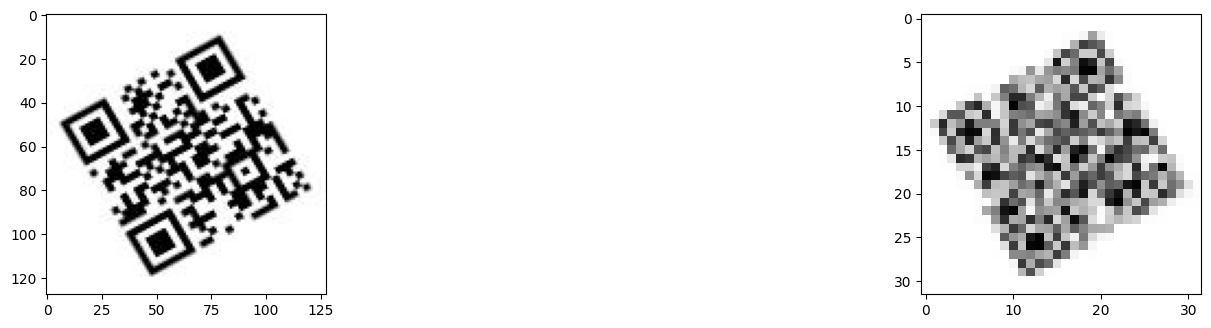

In [ ]:
X =  []
Xs = []

for features in array:
    X.append(features)

for features in array_small:
    Xs.append(features)

plt.figure(figsize=(16, 8))
X = np.array(X).reshape(-1, 128, 128, 3)
Xs = np.array(Xs).reshape(-1, 32, 32, 3)
plt.subplot(231)
plt.imshow(X[0], cmap = 'gray')
plt.subplot(233)
plt.imshow(Xs[0], cmap = 'gray')
plt.show()

## Dividir em treino e teste

In [ ]:
X_train,X_valid,y_train, y_valid = train_test_split(Xs, X, test_size = 0.20, random_state = 42)
X_train.shape

(3999, 32, 32, 3)

# Modelo GAN

## Função res_block

Essa função cria um bloco de resíduos para ser usado no gerador da GAN. Um bloco de resíduos consiste em duas camadas convolucionais com Batch Normalization e ativações PReLU. A saída do bloco é a soma da entrada original e da saída da segunda camada convolucional.

In [ ]:
def res_block(input_dim):
    model = Conv2D(64, (3,3), padding = 'same' )(input_dim)
    model = BatchNormalization()(model)
    model = PReLU(shared_axes = [1,2])(model)
    model = Conv2D(64, (3,3), padding = 'same' )(model)
    model = BatchNormalization()(model)
    return add([input_dim, model])


## Função upscale_block

A função upscale_block, que cria um bloco responsável por aumentar a resolução das imagens. Ele inclui uma camada convolucional seguida de uma camada de Upsampling (aumento de escala) para duplicar o tamanho da imagem. A ativação PReLU é aplicada após o Upsampling.

In [ ]:
def upscale_block(input_dim):
    model = Conv2D(256,(3,3), strides=1, padding = 'same')(input_dim)
    model = UpSampling2D(size = (2,2))(model)
    model = PReLU(shared_axes=[1, 2])(model)
    return model


 ## Função generator

 Aqui, definimos a função generator, que cria a arquitetura do gerador da GAN de super resolução. O gerador recebe uma imagem de baixa resolução como entrada e produz uma imagem de alta resolução como saída. O gerador consiste em camadas convolucionais, blocos de resíduos (quantidade definida por res_range) e blocos de aumento de escala (quantidade definida por upscale_range).

In [ ]:
def generator(input, res_range = 1,upscale_range=1):
    model = Conv2D(64,(9,9), strides=1, padding = 'same')(input)
    model = PReLU(shared_axes = [1,2])(model)
    model1 = model
    for i in range(res_range):
        model = res_block(model)
    model = Conv2D(64, (3,3), padding = 'same' )(model)
    model = BatchNormalization()(model)
    model = add([model,model1])
    for i in range(upscale_range):
        model  =upscale_block(model)
    output = Conv2D(3, (9,9),  padding='same')(model)
    return Model(input, output)


## Função discrim_block

Nesta célula, definimos a função discrim_block, que cria um bloco de camadas para o discriminador da GAN. Este bloco consiste em uma camada convolucional, seguida de Batch Normalization e ativação LeakyReLU.

In [1]:
def discrim_block(input_dim, fmaps = 64, strides = 1):
    model = Conv2D(fmaps, (3,3), padding = 'same', strides  = strides)(input_dim)
    model = BatchNormalization()(model)
    model = LeakyReLU()(model)
    return model


## Função discriminator

Aqui, definimos a função discriminator, que cria a arquitetura do discriminador da GAN de super resolução. O discriminador recebe uma imagem de alta resolução como entrada e produz uma única saída que indica a autenticidade da imagem.

In [ ]:
def discriminator(input):
    model = Conv2D(64,(3,3),padding='same')(input)
    model = LeakyReLU()(model)
    model = discrim_block(model, strides = 2)
    model = discrim_block(model, fmaps  = 128)
    model = discrim_block(model, fmaps = 128, strides = 2)
    model = discrim_block(model, fmaps=256)
    model = discrim_block(model, fmaps=256, strides=2)
    model = discrim_block(model, fmaps=512)
    model = discrim_block(model, fmaps=512, strides=2)
    model = Flatten()(model)
    model = Dense(1024)(model)
    model = LeakyReLU(alpha = 0.2)(model)
    out = Dense(1, activation='sigmoid')(model)
    return Model(input, out)

## Função build_vgg

Nesta célula, definimos a função build_vgg, que cria uma rede VGG19 pré-treinada. Essa rede será usada posteriormente para calcular a perda perceptual.

In [ ]:
def build_vgg(hr_shape):
    vgg = VGG19(weights="imagenet", include_top=False, input_shape=hr_shape)
    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)


##  Função create_comb

Finalmente, nesta célula, definimos a função create_comb, que combina o gerador, o discriminador e a rede VGG19 para criar o modelo completo da GAN de super resolução. Esta função recebe as várias partes da GAN e suas entradas, produzindo um modelo combinado que será usado durante o treinamento.

In [ ]:
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)

    gen_features = vgg(gen_img)

    disc_model.trainable = False
    validity = disc_model(gen_img)

    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])

O código abaixo define a arquitetura de uma GAN (Generative Adversarial Network) para realizar o processo de super-resolução de imagens. A super-resolução envolve a geração de imagens de alta resolução a partir de imagens de baixa resolução, e esse código cria os componentes principais da GAN, incluindo o gerador, o discriminador e uma rede VGG (Visual Geometry Group) preexistente para uso em cálculos de perda perceptual. Aqui está uma explicação passo a passo:

1. `hr_shape` e `lr_shape` são variáveis que definem as dimensões das imagens de alta resolução (hr) e baixa resolução (lr), com base nos dados de treinamento (`X_train` e `y_train`). As dimensões incluem a altura, a largura e o número de canais de cor (3 para imagens RGB).

2. `lr_ip` e `hr_ip` são camadas de entrada (input layers) para as imagens de baixa e alta resolução, respectivamente. Elas definem a forma das imagens que serão fornecidas como entrada para as redes subsequentes.

3. Em seguida, o código cria o gerador usando a função `generator`, passando a camada de entrada `lr_ip`. O gerador é uma parte fundamental da GAN e é responsável por gerar imagens de alta resolução a partir das imagens de baixa resolução. O argumento `res_range` é usado para controlar o número de resíduos (residual blocks) na arquitetura do gerador, e `upscale_range` define o fator de escala para a super-resolução.

4. O resumo da arquitetura do gerador é impresso na saída para fornecer uma visão geral de sua estrutura.

5. O código então cria o discriminador usando a função `discriminator` e imprime um resumo de sua arquitetura. O discriminador é responsável por determinar se uma imagem de alta resolução é real ou gerada pelo gerador.

6. O discriminador é compilado com uma função de perda de entropia cruzada binária ("binary_crossentropy") e otimizador "adam". Isso prepara o discriminador para o treinamento adversarial.

7. Uma rede VGG é construída usando a função `build_vgg` com dimensões de entrada de (128, 128, 3), que correspondem às imagens de alta resolução. Essa rede VGG será usada para calcular a perda perceptual.

8. O resumo da arquitetura da rede VGG é impresso na saída.

9. A variável `vgg.trainable` é definida como `False` para garantir que os pesos da rede VGG não sejam treinados durante o treinamento da GAN. Isso permite que a rede VGG seja usada apenas para cálculos de perda, em vez de treinamento adicional.

10. Por fim, o código cria o modelo GAN combinado (`gan_model`) usando a função `create_comb`, que recebe o gerador, o discriminador, a rede VGG e as camadas de entrada `lr_ip` e `hr_ip`. Este modelo GAN combinado será usado para treinar o gerador e o discriminador em conjunto.


In [ ]:
hr_shape = (y_train.shape[1], y_train.shape[2], y_train.shape[3])
lr_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])

lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

generator = generator(lr_ip, res_range = 16, upscale_range=2)
generator.summary()

discriminator = discriminator(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
discriminator.summary()

vgg = build_vgg((128,128,3))
print(vgg.summary())
vgg.trainable = False

gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 64)           15616     ['input_1[0][0]']             
                                                                                                  
 p_re_lu (PReLU)             (None, 32, 32, 64)           64        ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 32, 32, 64)           36928     ['p_re_lu[0][0]']             
                                                                                              

In [ ]:
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 model (Functional)          (None, 128, 128, 3)          2044291   ['input_1[0][0]']             
                                                                                                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 model_1 (Functional)        (None, 1)                    3824928   ['model[0][0]']               
                                                          1                                 

In [ ]:
batch_size = 8
train_lr_batches = []
train_hr_batches = []

for it in range(int(y_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(y_train[start_idx:end_idx])
    train_lr_batches.append(X_train[start_idx:end_idx])

In [ ]:
epochs = 3

for e in range(epochs):

    fake_label = np.zeros((batch_size, 1)) # Atribua um rótulo 0 a todas as imagens falsas (geradas)
    real_label = np.ones((batch_size,1)) # Atribua um rótulo 1 a todas as imagens reais.

    # Crie listas vazias para preencher perdas de geração e disco.
    g_losses = []
    d_losses = []

    for b in tqdm(range(len(train_hr_batches))):
        lr_imgs = train_lr_batches[b] # Batch de imagens LR para treinamento
        hr_imgs = train_hr_batches[b] # Batch de imagens HR para treinamento

        fake_imgs = generator.predict_on_batch(lr_imgs) #Fake imagenss

        # Primeiro, treine o discriminador em imagens de RH falsas e reais.
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)

        # Agora, treine o gerador fixando o discriminador como não treinável
        discriminator.trainable = False

        # Média da perda do discriminador, apenas para fins de relatório.
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real)

        # Extraia recursos do VGG, para serem usados ​​no cálculo da perda
        image_features = vgg.predict(hr_imgs)

        # Treine o gerador via GAN.
        # Lembre-se que temos 2 perdas, perda adversária e perda de conteúdo (VGG)
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])

        # Salve as perdas em uma lista para que possamos calcular a média e relatar.
        d_losses.append(d_loss)
        g_losses.append(g_loss)

    # Converta a lista de perdas em uma matriz para facilitar a média
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)

    # Calcule as perdas médias para gerador e discriminador
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)

    # Relate o progresso durante o treinamento.
    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)

    if (e+1) % 10 == 0:
        generator.save("gen_e_"+ str(e+1) +".h5")

  0%|          | 0/499 [00:00<?, ?it/s]

1/1 [==============================] - 1s 668ms/step


  0%|          | 1/499 [00:52<7:19:14, 52.92s/it]

1/1 [==============================] - 0s 28ms/step


  0%|          | 2/499 [00:53<3:03:45, 22.18s/it]

1/1 [==============================] - 0s 18ms/step


  1%|          | 3/499 [00:53<1:41:07, 12.23s/it]

1/1 [==============================] - 0s 19ms/step


  1%|          | 4/499 [00:54<1:02:16,  7.55s/it]

1/1 [==============================] - 0s 19ms/step


  1%|          | 5/499 [00:54<40:51,  4.96s/it]  

1/1 [==============================] - 0s 18ms/step


  1%|          | 6/499 [00:55<27:57,  3.40s/it]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 7/499 [00:55<19:47,  2.41s/it]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 8/499 [00:55<14:31,  1.77s/it]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 9/499 [00:56<10:53,  1.33s/it]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 10/499 [00:56<08:27,  1.04s/it]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 11/499 [00:56<06:46,  1.20it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 12/499 [00:57<05:38,  1.44it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 13/499 [00:57<04:54,  1.65it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 14/499 [00:58<04:21,  1.86it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 15/499 [00:58<03:56,  2.05it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 16/499 [00:58<03:40,  2.19it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 17/499 [00:59<03:27,  2.32it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▎         | 18/499 [00:59<03:19,  2.41it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 19/499 [01:00<03:15,  2.46it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 20/499 [01:00<03:10,  2.51it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 21/499 [01:00<03:08,  2.54it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 22/499 [01:01<03:06,  2.56it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 23/499 [01:01<03:02,  2.61it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 24/499 [01:01<03:01,  2.61it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 25/499 [01:02<03:02,  2.60it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 26/499 [01:02<03:24,  2.32it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 27/499 [01:03<03:15,  2.41it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 28/499 [01:03<03:10,  2.48it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▌         | 29/499 [01:04<03:21,  2.33it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▌         | 30/499 [01:04<03:46,  2.07it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 31/499 [01:05<03:44,  2.08it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▋         | 32/499 [01:05<04:01,  1.93it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 33/499 [01:06<03:41,  2.10it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 34/499 [01:06<03:25,  2.26it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 35/499 [01:06<03:17,  2.35it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 36/499 [01:07<03:10,  2.43it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 37/499 [01:07<03:04,  2.50it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 38/499 [01:08<03:01,  2.55it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 39/499 [01:08<02:58,  2.57it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 40/499 [01:08<02:56,  2.60it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 41/499 [01:09<02:54,  2.62it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 42/499 [01:09<02:55,  2.61it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▊         | 43/499 [01:09<02:56,  2.59it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 44/499 [01:10<02:54,  2.60it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 45/499 [01:10<02:54,  2.60it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 46/499 [01:11<02:52,  2.62it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 47/499 [01:11<02:51,  2.64it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 48/499 [01:11<02:54,  2.58it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 49/499 [01:12<02:52,  2.60it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 50/499 [01:12<02:50,  2.63it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 51/499 [01:13<02:51,  2.61it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 52/499 [01:13<02:51,  2.61it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 53/499 [01:13<02:54,  2.56it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 54/499 [01:14<02:52,  2.58it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 55/499 [01:14<02:51,  2.59it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 56/499 [01:14<02:49,  2.61it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 57/499 [01:15<02:47,  2.64it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 58/499 [01:15<02:47,  2.63it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 59/499 [01:16<03:18,  2.22it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 60/499 [01:16<03:21,  2.18it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 61/499 [01:17<03:38,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 62/499 [01:17<03:48,  1.91it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 63/499 [01:18<03:29,  2.08it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 64/499 [01:18<03:14,  2.24it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 65/499 [01:19<03:09,  2.29it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 66/499 [01:19<03:02,  2.37it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 67/499 [01:19<03:01,  2.38it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▎        | 68/499 [01:20<02:55,  2.45it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 69/499 [01:20<02:51,  2.51it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 70/499 [01:21<02:48,  2.55it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 71/499 [01:21<02:47,  2.56it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 72/499 [01:21<02:45,  2.57it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 73/499 [01:22<02:45,  2.57it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▍        | 74/499 [01:22<02:44,  2.59it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 75/499 [01:23<02:47,  2.54it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 76/499 [01:23<02:45,  2.56it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 77/499 [01:23<02:43,  2.58it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 78/499 [01:24<02:40,  2.62it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 79/499 [01:24<02:42,  2.59it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 80/499 [01:25<03:10,  2.20it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 81/499 [01:25<03:01,  2.31it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 82/499 [01:25<02:54,  2.40it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 83/499 [01:26<02:49,  2.45it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 84/499 [01:26<02:46,  2.50it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 85/499 [01:27<02:47,  2.48it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 86/499 [01:27<02:44,  2.51it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 87/499 [01:28<02:59,  2.30it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 88/499 [01:28<03:20,  2.05it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 89/499 [01:29<03:32,  1.93it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 90/499 [01:29<03:30,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 91/499 [01:30<03:17,  2.06it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 92/499 [01:30<03:05,  2.19it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 93/499 [01:30<02:56,  2.30it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 94/499 [01:31<02:49,  2.40it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 95/499 [01:31<02:45,  2.44it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 96/499 [01:32<02:42,  2.48it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 97/499 [01:32<02:40,  2.51it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 98/499 [01:32<02:55,  2.28it/s]

1/1 [==============================] - 0s 43ms/step


 20%|█▉        | 99/499 [01:33<03:08,  2.12it/s]

1/1 [==============================] - 0s 72ms/step


 20%|██        | 100/499 [01:34<03:44,  1.78it/s]

1/1 [==============================] - 0s 48ms/step


 20%|██        | 101/499 [01:34<03:56,  1.68it/s]

1/1 [==============================] - 0s 32ms/step


 20%|██        | 102/499 [01:35<04:22,  1.51it/s]

1/1 [==============================] - 0s 47ms/step


 21%|██        | 103/499 [01:36<04:30,  1.46it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 104/499 [01:37<04:14,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 105/499 [01:37<03:42,  1.77it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 106/499 [01:37<03:20,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 107/499 [01:38<03:04,  2.12it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 108/499 [01:38<02:57,  2.20it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 109/499 [01:39<02:48,  2.31it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 110/499 [01:39<02:49,  2.30it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 111/499 [01:39<02:57,  2.18it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 112/499 [01:40<02:59,  2.15it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 113/499 [01:41<03:14,  1.99it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 114/499 [01:41<03:27,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 115/499 [01:42<03:14,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 116/499 [01:42<02:59,  2.13it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 117/499 [01:42<02:48,  2.27it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▎       | 118/499 [01:43<02:44,  2.32it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 119/499 [01:43<02:38,  2.39it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 120/499 [01:44<02:35,  2.44it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 121/499 [01:44<02:32,  2.47it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 122/499 [01:44<02:30,  2.51it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 123/499 [01:45<02:28,  2.53it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 124/499 [01:45<02:30,  2.49it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 125/499 [01:46<02:27,  2.53it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 126/499 [01:46<02:29,  2.49it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 127/499 [01:46<02:30,  2.47it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 128/499 [01:47<02:30,  2.47it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 129/499 [01:47<02:27,  2.50it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 130/499 [01:48<02:26,  2.52it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 131/499 [01:48<02:26,  2.52it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▋       | 132/499 [01:48<02:26,  2.51it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 133/499 [01:49<02:25,  2.52it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 134/499 [01:49<02:23,  2.54it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 135/499 [01:50<02:37,  2.31it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 136/499 [01:50<02:30,  2.40it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 137/499 [01:51<02:42,  2.23it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 138/499 [01:51<02:43,  2.21it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 139/499 [01:52<02:51,  2.10it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 140/499 [01:52<03:02,  1.96it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 141/499 [01:53<02:56,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 142/499 [01:53<02:51,  2.08it/s]

1/1 [==============================] - 0s 36ms/step


 29%|██▊       | 143/499 [01:53<02:51,  2.07it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 144/499 [01:54<02:41,  2.20it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 145/499 [01:54<02:33,  2.30it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 146/499 [01:55<02:31,  2.34it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 147/499 [01:55<02:26,  2.40it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 148/499 [01:55<02:23,  2.44it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 149/499 [01:56<02:21,  2.48it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 150/499 [01:56<02:19,  2.49it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 151/499 [01:57<02:22,  2.44it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 152/499 [01:57<02:19,  2.49it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 153/499 [01:57<02:17,  2.52it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 154/499 [01:58<02:17,  2.50it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 155/499 [01:58<02:19,  2.47it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 156/499 [01:59<02:18,  2.48it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 157/499 [01:59<02:15,  2.52it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 158/499 [01:59<02:15,  2.52it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 159/499 [02:00<02:13,  2.54it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 160/499 [02:00<02:13,  2.54it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 161/499 [02:01<02:12,  2.56it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 162/499 [02:01<02:13,  2.52it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 163/499 [02:01<02:15,  2.48it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 164/499 [02:02<02:12,  2.52it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 165/499 [02:02<02:11,  2.54it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 166/499 [02:03<02:09,  2.58it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 167/499 [02:03<02:07,  2.60it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▎      | 168/499 [02:03<02:07,  2.60it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 169/499 [02:04<02:26,  2.26it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 170/499 [02:05<02:42,  2.02it/s]

1/1 [==============================] - 0s 45ms/step


 34%|███▍      | 171/499 [02:05<02:46,  1.97it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 172/499 [02:06<02:57,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 173/499 [02:06<02:53,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 174/499 [02:07<02:38,  2.05it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 175/499 [02:07<02:28,  2.18it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 176/499 [02:07<02:20,  2.29it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 177/499 [02:08<02:18,  2.33it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 178/499 [02:08<02:13,  2.40it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 179/499 [02:09<02:13,  2.40it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 180/499 [02:09<02:09,  2.46it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▋      | 181/499 [02:09<02:07,  2.49it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▋      | 182/499 [02:10<02:08,  2.46it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 183/499 [02:10<02:06,  2.50it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 184/499 [02:11<02:05,  2.52it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 185/499 [02:11<02:03,  2.54it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 186/499 [02:11<02:02,  2.55it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 187/499 [02:12<02:03,  2.53it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 188/499 [02:12<02:04,  2.50it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 189/499 [02:13<02:03,  2.52it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 190/499 [02:13<02:04,  2.49it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 191/499 [02:13<02:02,  2.52it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 192/499 [02:14<02:00,  2.54it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▊      | 193/499 [02:14<01:59,  2.57it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 194/499 [02:14<01:57,  2.60it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 195/499 [02:15<01:57,  2.58it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 196/499 [02:15<01:57,  2.58it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 197/499 [02:16<01:57,  2.58it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███▉      | 198/499 [02:16<02:18,  2.17it/s]

1/1 [==============================] - 0s 26ms/step


 40%|███▉      | 199/499 [02:17<02:21,  2.12it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 200/499 [02:17<02:32,  1.97it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 201/499 [02:18<02:35,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 202/499 [02:18<02:22,  2.08it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 203/499 [02:19<02:13,  2.22it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 204/499 [02:19<02:07,  2.32it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 205/499 [02:19<02:03,  2.39it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████▏     | 206/499 [02:20<02:03,  2.37it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████▏     | 207/499 [02:20<01:59,  2.44it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 208/499 [02:21<02:00,  2.41it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 209/499 [02:21<01:59,  2.42it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 210/499 [02:22<02:00,  2.40it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 211/499 [02:22<01:57,  2.45it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 212/499 [02:22<01:56,  2.47it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 213/499 [02:23<01:54,  2.51it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 214/499 [02:23<01:53,  2.51it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 215/499 [02:23<01:52,  2.53it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 216/499 [02:24<01:51,  2.55it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 217/499 [02:24<01:53,  2.49it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 218/499 [02:25<01:51,  2.52it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 219/499 [02:25<01:50,  2.54it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 220/499 [02:25<01:48,  2.56it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 221/499 [02:26<01:48,  2.57it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 222/499 [02:26<01:49,  2.52it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 223/499 [02:27<01:48,  2.55it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 224/499 [02:27<01:47,  2.57it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 225/499 [02:27<01:46,  2.56it/s]

1/1 [==============================] - 0s 39ms/step


 45%|████▌     | 226/499 [02:28<02:02,  2.24it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 227/499 [02:28<02:06,  2.15it/s]

1/1 [==============================] - 0s 30ms/step


 46%|████▌     | 228/499 [02:29<02:17,  1.98it/s]

1/1 [==============================] - 0s 30ms/step


 46%|████▌     | 229/499 [02:30<02:28,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 230/499 [02:30<02:16,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 231/499 [02:31<02:08,  2.09it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 232/499 [02:31<01:59,  2.23it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 233/499 [02:31<01:56,  2.28it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 234/499 [02:32<01:52,  2.35it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 235/499 [02:32<01:51,  2.37it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 236/499 [02:33<01:47,  2.44it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 237/499 [02:33<01:45,  2.49it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 238/499 [02:33<01:43,  2.51it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 239/499 [02:34<01:44,  2.49it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 240/499 [02:34<01:46,  2.44it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 241/499 [02:35<01:43,  2.48it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 242/499 [02:35<01:41,  2.53it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▊     | 243/499 [02:35<01:41,  2.53it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 244/499 [02:36<01:41,  2.52it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 245/499 [02:36<01:40,  2.53it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 246/499 [02:36<01:39,  2.55it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 247/499 [02:37<01:37,  2.58it/s]

1/1 [==============================] - 0s 19ms/step


 50%|████▉     | 248/499 [02:37<01:36,  2.59it/s]

1/1 [==============================] - 0s 18ms/step


 50%|████▉     | 249/499 [02:38<01:37,  2.57it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 250/499 [02:38<01:37,  2.57it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 251/499 [02:39<01:49,  2.27it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 252/499 [02:39<01:44,  2.36it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 253/499 [02:39<01:41,  2.42it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 254/499 [02:40<01:49,  2.24it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████     | 255/499 [02:41<02:01,  2.01it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████▏    | 256/499 [02:41<02:04,  1.95it/s]

1/1 [==============================] - 0s 43ms/step


 52%|█████▏    | 257/499 [02:42<02:01,  1.99it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 258/499 [02:42<01:56,  2.08it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 259/499 [02:42<01:48,  2.21it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 260/499 [02:43<01:42,  2.33it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 261/499 [02:43<01:39,  2.40it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 262/499 [02:44<01:36,  2.45it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 263/499 [02:44<01:34,  2.51it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 264/499 [02:44<01:32,  2.54it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 265/499 [02:45<01:34,  2.49it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 266/499 [02:45<01:33,  2.50it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▎    | 267/499 [02:45<01:32,  2.51it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 268/499 [02:46<01:31,  2.54it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 269/499 [02:46<01:30,  2.55it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 270/499 [02:47<01:29,  2.55it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 271/499 [02:47<01:28,  2.56it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 272/499 [02:47<01:28,  2.57it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 273/499 [02:48<01:30,  2.51it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 274/499 [02:48<01:30,  2.48it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 275/499 [02:49<01:31,  2.45it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 276/499 [02:49<01:29,  2.49it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 277/499 [02:49<01:28,  2.51it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 278/499 [02:50<01:27,  2.53it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 279/499 [02:50<01:26,  2.54it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 280/499 [02:51<01:25,  2.55it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▋    | 281/499 [02:51<01:24,  2.57it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 282/499 [02:51<01:24,  2.56it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 283/499 [02:52<01:24,  2.56it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 284/499 [02:52<01:29,  2.39it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 285/499 [02:53<01:33,  2.28it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 286/499 [02:53<01:42,  2.07it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 287/499 [02:54<01:43,  2.04it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 288/499 [02:54<01:36,  2.19it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 289/499 [02:55<01:31,  2.29it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 290/499 [02:55<01:28,  2.36it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 291/499 [02:55<01:26,  2.41it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▊    | 292/499 [02:56<01:24,  2.46it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▊    | 293/499 [02:56<01:22,  2.50it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 294/499 [02:57<01:21,  2.52it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 295/499 [02:57<01:19,  2.55it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 296/499 [02:57<01:19,  2.55it/s]

1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 297/499 [02:58<01:19,  2.56it/s]

1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 298/499 [02:58<01:20,  2.48it/s]

1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 299/499 [02:59<01:19,  2.50it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 300/499 [02:59<01:19,  2.49it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 301/499 [02:59<01:19,  2.50it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 302/499 [03:00<01:17,  2.53it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 303/499 [03:00<01:17,  2.54it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 304/499 [03:01<01:17,  2.53it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 305/499 [03:01<01:16,  2.54it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 306/499 [03:01<01:15,  2.55it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 307/499 [03:02<01:15,  2.54it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 308/499 [03:02<01:15,  2.54it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 309/499 [03:02<01:16,  2.50it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 310/499 [03:03<01:15,  2.50it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 311/499 [03:03<01:14,  2.52it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 312/499 [03:04<01:13,  2.54it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 313/499 [03:04<01:16,  2.42it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 314/499 [03:05<01:17,  2.39it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 315/499 [03:05<01:20,  2.28it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 316/499 [03:06<01:24,  2.18it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▎   | 317/499 [03:06<01:23,  2.18it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▎   | 318/499 [03:06<01:20,  2.24it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 319/499 [03:07<01:17,  2.32it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 320/499 [03:07<01:15,  2.36it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 321/499 [03:08<01:14,  2.40it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 322/499 [03:08<01:12,  2.45it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 323/499 [03:08<01:11,  2.48it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 324/499 [03:09<01:09,  2.50it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 325/499 [03:09<01:09,  2.51it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 326/499 [03:10<01:09,  2.48it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 327/499 [03:10<01:09,  2.47it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 328/499 [03:10<01:08,  2.50it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 329/499 [03:11<01:07,  2.53it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 330/499 [03:11<01:07,  2.50it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 331/499 [03:12<01:08,  2.45it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 332/499 [03:12<01:07,  2.49it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 333/499 [03:12<01:06,  2.50it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 334/499 [03:13<01:05,  2.52it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 335/499 [03:13<01:05,  2.49it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 336/499 [03:14<01:05,  2.50it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 337/499 [03:14<01:04,  2.52it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 338/499 [03:14<01:03,  2.53it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 339/499 [03:15<01:02,  2.54it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 340/499 [03:15<01:02,  2.54it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 341/499 [03:16<01:01,  2.55it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▊   | 342/499 [03:16<01:01,  2.57it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▊   | 343/499 [03:17<01:12,  2.17it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 344/499 [03:17<01:09,  2.22it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 345/499 [03:18<01:18,  1.97it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 346/499 [03:18<01:24,  1.82it/s]

1/1 [==============================] - 0s 18ms/step


 70%|██████▉   | 347/499 [03:19<01:16,  1.99it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 348/499 [03:19<01:10,  2.14it/s]

1/1 [==============================] - 0s 18ms/step


 70%|██████▉   | 349/499 [03:19<01:06,  2.24it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 350/499 [03:20<01:03,  2.33it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 351/499 [03:20<01:02,  2.39it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 352/499 [03:21<01:01,  2.38it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 353/499 [03:21<00:59,  2.44it/s]

1/1 [==============================] - 0s 85ms/step


 71%|███████   | 354/499 [03:22<01:11,  2.03it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 355/499 [03:22<01:08,  2.11it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████▏  | 356/499 [03:23<01:07,  2.12it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 357/499 [03:23<01:10,  2.01it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 358/499 [03:24<01:06,  2.11it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 359/499 [03:24<01:03,  2.22it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 360/499 [03:24<01:00,  2.30it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 361/499 [03:25<00:58,  2.37it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 362/499 [03:25<00:56,  2.43it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 363/499 [03:26<00:56,  2.42it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 364/499 [03:26<00:54,  2.47it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 365/499 [03:27<01:00,  2.23it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 366/499 [03:27<00:56,  2.34it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▎  | 367/499 [03:27<00:54,  2.41it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▎  | 368/499 [03:28<00:58,  2.23it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 369/499 [03:28<01:01,  2.10it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 370/499 [03:29<01:08,  1.90it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 371/499 [03:30<01:12,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████▍  | 372/499 [03:30<01:07,  1.88it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▍  | 373/499 [03:31<01:06,  1.89it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 374/499 [03:31<01:00,  2.06it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 375/499 [03:31<00:56,  2.19it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 376/499 [03:32<00:53,  2.29it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 377/499 [03:32<00:51,  2.37it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 378/499 [03:33<00:50,  2.37it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 379/499 [03:33<00:49,  2.41it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 380/499 [03:33<00:48,  2.45it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▋  | 381/499 [03:34<00:47,  2.49it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 382/499 [03:34<00:46,  2.52it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 383/499 [03:35<00:46,  2.50it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 384/499 [03:35<00:45,  2.53it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 385/499 [03:35<00:45,  2.53it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 386/499 [03:36<00:44,  2.54it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 387/499 [03:36<00:44,  2.50it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 388/499 [03:37<00:43,  2.53it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 389/499 [03:37<00:44,  2.49it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 390/499 [03:37<00:43,  2.51it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 391/499 [03:38<00:42,  2.52it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▊  | 392/499 [03:38<00:42,  2.54it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 393/499 [03:39<00:41,  2.56it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 394/499 [03:39<00:40,  2.56it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 395/499 [03:39<00:40,  2.54it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 396/499 [03:40<00:40,  2.54it/s]

1/1 [==============================] - 0s 23ms/step


 80%|███████▉  | 397/499 [03:40<00:40,  2.53it/s]

1/1 [==============================] - 0s 29ms/step


 80%|███████▉  | 398/499 [03:41<00:42,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


 80%|███████▉  | 399/499 [03:41<00:47,  2.09it/s]

1/1 [==============================] - 0s 29ms/step


 80%|████████  | 400/499 [03:42<00:51,  1.92it/s]

1/1 [==============================] - 0s 32ms/step


 80%|████████  | 401/499 [03:42<00:50,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 402/499 [03:43<00:49,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 403/499 [03:43<00:45,  2.10it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 404/499 [03:44<00:42,  2.22it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 405/499 [03:44<00:41,  2.27it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████▏ | 406/499 [03:44<00:39,  2.35it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 407/499 [03:45<00:38,  2.38it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 408/499 [03:45<00:38,  2.39it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 409/499 [03:46<00:37,  2.40it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 410/499 [03:46<00:36,  2.44it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 411/499 [03:46<00:35,  2.47it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 412/499 [03:47<00:34,  2.51it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 413/499 [03:47<00:34,  2.53it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 414/499 [03:48<00:33,  2.55it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 415/499 [03:48<00:33,  2.49it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 416/499 [03:48<00:32,  2.52it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▎ | 417/499 [03:49<00:32,  2.53it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 418/499 [03:49<00:32,  2.47it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 419/499 [03:50<00:32,  2.48it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 420/499 [03:50<00:31,  2.50it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 421/499 [03:50<00:31,  2.46it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 422/499 [03:51<00:31,  2.45it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 423/499 [03:51<00:30,  2.47it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 424/499 [03:52<00:30,  2.46it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 425/499 [03:52<00:29,  2.50it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▌ | 426/499 [03:52<00:29,  2.49it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 427/499 [03:53<00:34,  2.10it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 428/499 [03:54<00:36,  1.93it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▌ | 429/499 [03:54<00:35,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 430/499 [03:55<00:33,  2.07it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▋ | 431/499 [03:55<00:33,  2.03it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 432/499 [03:56<00:31,  2.13it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 433/499 [03:56<00:29,  2.24it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 434/499 [03:56<00:28,  2.26it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 435/499 [03:57<00:27,  2.34it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 436/499 [03:57<00:26,  2.41it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 437/499 [03:58<00:25,  2.46it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 438/499 [03:58<00:24,  2.50it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 439/499 [03:58<00:24,  2.47it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 440/499 [03:59<00:23,  2.50it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 441/499 [03:59<00:23,  2.48it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▊ | 442/499 [04:00<00:22,  2.49it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 443/499 [04:00<00:22,  2.52it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 444/499 [04:00<00:21,  2.52it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 445/499 [04:01<00:21,  2.54it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 446/499 [04:01<00:21,  2.50it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 447/499 [04:02<00:20,  2.52it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 448/499 [04:02<00:20,  2.52it/s]

1/1 [==============================] - 0s 26ms/step


 90%|████████▉ | 449/499 [04:02<00:20,  2.47it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 450/499 [04:03<00:19,  2.46it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 451/499 [04:03<00:19,  2.48it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 452/499 [04:04<00:18,  2.50it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 453/499 [04:04<00:18,  2.53it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 454/499 [04:04<00:19,  2.30it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 455/499 [04:05<00:21,  2.07it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████▏| 456/499 [04:06<00:22,  1.94it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 457/499 [04:06<00:22,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 458/499 [04:07<00:20,  1.99it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 459/499 [04:07<00:19,  2.08it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 460/499 [04:08<00:17,  2.17it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 461/499 [04:08<00:16,  2.26it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 462/499 [04:08<00:15,  2.33it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 463/499 [04:09<00:15,  2.39it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 464/499 [04:09<00:15,  2.23it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 465/499 [04:10<00:14,  2.31it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 466/499 [04:10<00:14,  2.33it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▎| 467/499 [04:10<00:13,  2.38it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 468/499 [04:11<00:12,  2.43it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 469/499 [04:11<00:12,  2.47it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 470/499 [04:12<00:11,  2.49it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 471/499 [04:12<00:11,  2.52it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 472/499 [04:12<00:10,  2.53it/s]

1/1 [==============================] - 0s 24ms/step


 95%|█████████▍| 473/499 [04:13<00:10,  2.54it/s]

1/1 [==============================] - 0s 24ms/step


 95%|█████████▍| 474/499 [04:13<00:09,  2.54it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▌| 475/499 [04:14<00:09,  2.47it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 476/499 [04:14<00:10,  2.27it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 477/499 [04:15<00:09,  2.35it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 478/499 [04:15<00:08,  2.33it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 479/499 [04:15<00:08,  2.39it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 480/499 [04:16<00:07,  2.44it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 481/499 [04:16<00:07,  2.48it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 482/499 [04:17<00:06,  2.51it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 483/499 [04:17<00:07,  2.15it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 484/499 [04:18<00:07,  2.11it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 485/499 [04:18<00:06,  2.11it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 486/499 [04:19<00:06,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 487/499 [04:19<00:05,  2.09it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 488/499 [04:19<00:04,  2.21it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 489/499 [04:20<00:04,  2.26it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 490/499 [04:20<00:03,  2.29it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 491/499 [04:21<00:03,  2.34it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 492/499 [04:21<00:02,  2.40it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 493/499 [04:22<00:02,  2.44it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 494/499 [04:22<00:02,  2.42it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 495/499 [04:22<00:01,  2.45it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 496/499 [04:23<00:01,  2.46it/s]

1/1 [==============================] - 0s 19ms/step


100%|█████████▉| 497/499 [04:23<00:00,  2.49it/s]

1/1 [==============================] - 0s 18ms/step


100%|█████████▉| 498/499 [04:24<00:00,  2.51it/s]

1/1 [==============================] - 0s 27ms/step


100%|██████████| 499/499 [04:24<00:00,  1.89it/s]


epoch: 1 g_loss: 963862.9837174349 d_loss: [0.94139698 0.95666333]


  0%|          | 0/499 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 1/499 [00:00<03:28,  2.39it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 2/499 [00:00<03:22,  2.46it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 3/499 [00:01<03:17,  2.51it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 4/499 [00:01<03:16,  2.52it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 5/499 [00:02<03:19,  2.48it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 6/499 [00:02<03:19,  2.47it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 7/499 [00:02<03:18,  2.48it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 8/499 [00:03<03:17,  2.48it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 9/499 [00:03<03:15,  2.50it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 10/499 [00:04<03:20,  2.44it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 11/499 [00:04<03:17,  2.48it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 12/499 [00:04<03:15,  2.50it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 13/499 [00:05<03:20,  2.42it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 14/499 [00:05<03:30,  2.30it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 15/499 [00:06<03:36,  2.23it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 16/499 [00:06<03:44,  2.15it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 17/499 [00:07<03:44,  2.15it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▎         | 18/499 [00:07<03:40,  2.18it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 19/499 [00:08<03:33,  2.25it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 20/499 [00:08<03:24,  2.34it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 21/499 [00:08<03:18,  2.40it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 22/499 [00:09<03:15,  2.44it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 23/499 [00:09<03:13,  2.47it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 24/499 [00:10<03:11,  2.48it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 25/499 [00:10<03:10,  2.49it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 26/499 [00:10<03:09,  2.50it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 27/499 [00:11<03:07,  2.52it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 28/499 [00:11<03:05,  2.53it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 29/499 [00:11<03:05,  2.54it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 30/499 [00:12<03:05,  2.53it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 31/499 [00:12<03:06,  2.51it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 32/499 [00:13<03:13,  2.41it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 33/499 [00:13<03:09,  2.45it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 34/499 [00:14<03:07,  2.48it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 35/499 [00:14<03:06,  2.49it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 36/499 [00:14<03:04,  2.51it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 37/499 [00:15<03:03,  2.52it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 38/499 [00:15<03:02,  2.53it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 39/499 [00:16<03:02,  2.52it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 40/499 [00:16<03:02,  2.52it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 41/499 [00:16<03:07,  2.44it/s]

1/1 [==============================] - 0s 42ms/step


  8%|▊         | 42/499 [00:17<03:15,  2.34it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▊         | 43/499 [00:17<03:20,  2.27it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 44/499 [00:18<03:41,  2.06it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▉         | 45/499 [00:18<03:37,  2.09it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 46/499 [00:19<03:41,  2.05it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 47/499 [00:19<03:28,  2.17it/s]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 48/499 [00:20<03:19,  2.26it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 49/499 [00:20<03:11,  2.35it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 50/499 [00:21<03:25,  2.19it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 51/499 [00:21<03:17,  2.27it/s]

1/1 [==============================] - 0s 25ms/step


 10%|█         | 52/499 [00:21<03:11,  2.33it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 53/499 [00:22<03:10,  2.34it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 54/499 [00:22<03:05,  2.40it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 55/499 [00:23<03:01,  2.44it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 56/499 [00:23<03:05,  2.39it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█▏        | 57/499 [00:23<03:02,  2.42it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 58/499 [00:24<02:59,  2.46it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 59/499 [00:24<02:58,  2.47it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 60/499 [00:25<03:17,  2.22it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 61/499 [00:25<03:10,  2.30it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 62/499 [00:26<03:08,  2.32it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 63/499 [00:26<03:03,  2.37it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 64/499 [00:26<03:00,  2.41it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 65/499 [00:27<02:58,  2.43it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 66/499 [00:27<02:55,  2.47it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 67/499 [00:28<02:54,  2.48it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▎        | 68/499 [00:28<02:55,  2.46it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 69/499 [00:28<02:52,  2.49it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 70/499 [00:29<02:51,  2.50it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 71/499 [00:29<03:21,  2.13it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 72/499 [00:30<03:21,  2.12it/s]

1/1 [==============================] - 0s 39ms/step


 15%|█▍        | 73/499 [00:30<03:22,  2.11it/s]

1/1 [==============================] - 0s 37ms/step


 15%|█▍        | 74/499 [00:31<03:49,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 75/499 [00:31<03:29,  2.03it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 76/499 [00:32<03:16,  2.16it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 77/499 [00:32<03:07,  2.25it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 78/499 [00:33<03:01,  2.32it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 79/499 [00:33<02:56,  2.38it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 80/499 [00:33<02:53,  2.41it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 81/499 [00:34<02:56,  2.37it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 82/499 [00:34<02:52,  2.42it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 83/499 [00:35<02:50,  2.43it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 84/499 [00:35<02:49,  2.45it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 85/499 [00:35<02:47,  2.47it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 86/499 [00:36<02:46,  2.48it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 87/499 [00:36<02:45,  2.48it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 88/499 [00:37<02:45,  2.48it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 89/499 [00:37<02:53,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 90/499 [00:38<02:53,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 91/499 [00:38<02:55,  2.32it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 92/499 [00:38<02:51,  2.37it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▊        | 93/499 [00:39<02:48,  2.42it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 94/499 [00:39<02:48,  2.40it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 95/499 [00:40<02:45,  2.44it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 96/499 [00:40<02:43,  2.46it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 97/499 [00:40<02:42,  2.47it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 98/499 [00:41<02:41,  2.48it/s]

1/1 [==============================] - 0s 32ms/step


 20%|█▉        | 99/499 [00:41<03:00,  2.22it/s]

1/1 [==============================] - 0s 27ms/step


 20%|██        | 100/499 [00:42<03:19,  2.00it/s]

1/1 [==============================] - 0s 45ms/step


 20%|██        | 101/499 [00:43<03:36,  1.84it/s]

1/1 [==============================] - 0s 29ms/step


 20%|██        | 102/499 [00:43<03:30,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 103/499 [00:44<03:13,  2.05it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 104/499 [00:44<03:02,  2.16it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 105/499 [00:44<02:54,  2.26it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 106/499 [00:45<02:48,  2.34it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██▏       | 107/499 [00:45<02:44,  2.39it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 108/499 [00:46<02:41,  2.42it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 109/499 [00:46<02:41,  2.41it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 110/499 [00:46<02:42,  2.40it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 111/499 [00:47<02:39,  2.43it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 112/499 [00:47<02:38,  2.45it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 113/499 [00:48<02:36,  2.47it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 114/499 [00:48<02:34,  2.50it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 115/499 [00:48<02:33,  2.50it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 116/499 [00:49<02:31,  2.52it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 117/499 [00:49<02:31,  2.53it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 118/499 [00:50<02:31,  2.51it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 119/499 [00:50<02:30,  2.52it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 120/499 [00:50<02:30,  2.52it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 121/499 [00:51<02:29,  2.53it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 122/499 [00:51<02:28,  2.53it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 123/499 [00:52<02:28,  2.53it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 124/499 [00:52<02:29,  2.51it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 125/499 [00:52<02:28,  2.51it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 126/499 [00:53<02:27,  2.53it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 127/499 [00:53<02:26,  2.54it/s]

1/1 [==============================] - 0s 46ms/step


 26%|██▌       | 128/499 [00:54<02:40,  2.31it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 129/499 [00:54<02:59,  2.06it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 130/499 [00:55<03:15,  1.89it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▋       | 131/499 [00:55<03:07,  1.96it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▋       | 132/499 [00:56<02:55,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 133/499 [00:56<02:49,  2.17it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 134/499 [00:57<02:40,  2.27it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 135/499 [00:57<02:35,  2.34it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 136/499 [00:57<02:31,  2.39it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 137/499 [00:58<02:29,  2.42it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 138/499 [00:58<02:27,  2.44it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 139/499 [00:59<02:39,  2.25it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 140/499 [00:59<02:32,  2.35it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 141/499 [00:59<02:29,  2.40it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 142/499 [01:00<02:26,  2.44it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▊       | 143/499 [01:00<02:26,  2.44it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 144/499 [01:01<02:27,  2.41it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 145/499 [01:01<02:24,  2.45it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 146/499 [01:01<02:25,  2.43it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 147/499 [01:02<02:26,  2.40it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 148/499 [01:02<02:24,  2.42it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 149/499 [01:03<02:23,  2.44it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 150/499 [01:03<02:21,  2.47it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 151/499 [01:04<02:20,  2.48it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 152/499 [01:04<02:20,  2.47it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 153/499 [01:04<02:19,  2.49it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 154/499 [01:05<02:21,  2.44it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 155/499 [01:05<02:22,  2.41it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███▏      | 156/499 [01:06<02:28,  2.32it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███▏      | 157/499 [01:06<02:34,  2.22it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 158/499 [01:07<02:54,  1.95it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 159/499 [01:07<02:54,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 160/499 [01:08<02:44,  2.06it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 161/499 [01:08<02:35,  2.17it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 162/499 [01:09<02:29,  2.25it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 163/499 [01:09<02:38,  2.11it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 164/499 [01:09<02:29,  2.24it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 165/499 [01:10<02:23,  2.32it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 166/499 [01:10<02:20,  2.38it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 167/499 [01:11<02:17,  2.42it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 168/499 [01:11<02:16,  2.43it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 169/499 [01:11<02:14,  2.46it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 170/499 [01:12<02:13,  2.46it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 171/499 [01:12<02:11,  2.49it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 172/499 [01:13<02:11,  2.48it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 173/499 [01:13<02:10,  2.49it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 174/499 [01:13<02:09,  2.51it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 175/499 [01:14<02:08,  2.52it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 176/499 [01:14<02:07,  2.52it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 177/499 [01:15<02:09,  2.48it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 178/499 [01:15<02:08,  2.50it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 179/499 [01:15<02:07,  2.51it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 180/499 [01:16<02:07,  2.51it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▋      | 181/499 [01:16<02:06,  2.51it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 182/499 [01:17<02:06,  2.51it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 183/499 [01:17<02:07,  2.48it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 184/499 [01:17<02:05,  2.50it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 185/499 [01:18<02:23,  2.18it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 186/499 [01:19<02:38,  1.98it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 187/499 [01:19<02:48,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 188/499 [01:20<02:41,  1.93it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 189/499 [01:20<02:29,  2.08it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 190/499 [01:21<02:20,  2.21it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 191/499 [01:21<02:14,  2.29it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 192/499 [01:21<02:12,  2.31it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▊      | 193/499 [01:22<02:10,  2.34it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 194/499 [01:22<02:07,  2.40it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 195/499 [01:23<02:04,  2.44it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 196/499 [01:23<02:02,  2.48it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 197/499 [01:23<02:00,  2.50it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 198/499 [01:24<02:01,  2.47it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 199/499 [01:24<01:59,  2.50it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 200/499 [01:25<01:59,  2.50it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 201/499 [01:25<01:59,  2.50it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 202/499 [01:25<01:59,  2.48it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 203/499 [01:26<01:58,  2.50it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 204/499 [01:26<01:57,  2.51it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 205/499 [01:27<01:56,  2.52it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████▏     | 206/499 [01:27<01:55,  2.53it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████▏     | 207/499 [01:27<01:54,  2.54it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 208/499 [01:28<01:57,  2.49it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 209/499 [01:28<01:56,  2.50it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 210/499 [01:29<01:55,  2.51it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 211/499 [01:29<01:54,  2.52it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 212/499 [01:29<01:53,  2.52it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 213/499 [01:30<01:54,  2.51it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 214/499 [01:30<02:00,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 215/499 [01:31<02:04,  2.29it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 216/499 [01:31<02:21,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 217/499 [01:32<02:20,  2.00it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 218/499 [01:32<02:11,  2.14it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 219/499 [01:33<02:05,  2.24it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 220/499 [01:33<02:02,  2.28it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 221/499 [01:33<02:00,  2.31it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 222/499 [01:34<01:57,  2.36it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 223/499 [01:34<01:54,  2.41it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 224/499 [01:35<01:55,  2.38it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 225/499 [01:35<02:03,  2.21it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 226/499 [01:36<01:58,  2.30it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 227/499 [01:36<01:57,  2.31it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 228/499 [01:36<01:54,  2.37it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 229/499 [01:37<01:51,  2.42it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 230/499 [01:37<01:49,  2.45it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▋     | 231/499 [01:38<01:48,  2.47it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 232/499 [01:38<01:47,  2.48it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 233/499 [01:39<01:56,  2.28it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 234/499 [01:39<01:53,  2.34it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 235/499 [01:39<01:50,  2.39it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 236/499 [01:40<01:48,  2.43it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 237/499 [01:40<01:46,  2.47it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 238/499 [01:41<01:47,  2.42it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 239/499 [01:41<01:48,  2.41it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 240/499 [01:41<01:47,  2.42it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 241/499 [01:42<01:45,  2.44it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 242/499 [01:42<02:01,  2.11it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▊     | 243/499 [01:43<02:03,  2.07it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 244/499 [01:43<02:05,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 245/499 [01:44<02:08,  1.98it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 246/499 [01:44<01:59,  2.12it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 247/499 [01:45<01:53,  2.22it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 248/499 [01:45<01:59,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 249/499 [01:46<01:52,  2.22it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 250/499 [01:46<01:51,  2.23it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 251/499 [01:47<01:50,  2.25it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 252/499 [01:47<01:45,  2.33it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 253/499 [01:47<01:44,  2.35it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 254/499 [01:48<01:41,  2.42it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 255/499 [01:48<01:39,  2.46it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 256/499 [01:49<01:38,  2.48it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 257/499 [01:49<01:38,  2.47it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 258/499 [01:49<01:37,  2.48it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 259/499 [01:50<01:35,  2.50it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 260/499 [01:50<01:35,  2.52it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 261/499 [01:51<01:36,  2.48it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 262/499 [01:51<01:37,  2.44it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 263/499 [01:51<01:36,  2.46it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 264/499 [01:52<01:35,  2.47it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 265/499 [01:52<01:33,  2.50it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 266/499 [01:53<01:32,  2.53it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▎    | 267/499 [01:53<01:31,  2.53it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▎    | 268/499 [01:53<01:31,  2.54it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 269/499 [01:54<01:33,  2.47it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▍    | 270/499 [01:54<01:39,  2.31it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 271/499 [01:55<01:41,  2.25it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▍    | 272/499 [01:55<01:52,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▍    | 273/499 [01:56<01:52,  2.01it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▍    | 274/499 [01:56<01:52,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 275/499 [01:57<01:44,  2.15it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 276/499 [01:57<01:39,  2.25it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 277/499 [01:58<01:36,  2.30it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 278/499 [01:58<01:33,  2.37it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 279/499 [01:58<01:31,  2.42it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 280/499 [01:59<01:31,  2.40it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 281/499 [01:59<01:29,  2.44it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 282/499 [02:00<01:28,  2.46it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 283/499 [02:00<01:28,  2.45it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 284/499 [02:00<01:28,  2.42it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 285/499 [02:01<01:27,  2.45it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 286/499 [02:01<01:27,  2.42it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 287/499 [02:02<01:26,  2.45it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 288/499 [02:02<01:34,  2.24it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 289/499 [02:03<01:30,  2.32it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 290/499 [02:03<01:28,  2.37it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 291/499 [02:03<01:26,  2.40it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 292/499 [02:04<01:26,  2.39it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▊    | 293/499 [02:04<01:25,  2.41it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 294/499 [02:05<01:26,  2.37it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 295/499 [02:05<01:24,  2.41it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 296/499 [02:05<01:24,  2.39it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 297/499 [02:06<01:45,  1.92it/s]

1/1 [==============================] - 0s 38ms/step


 60%|█████▉    | 298/499 [02:07<01:44,  1.92it/s]

1/1 [==============================] - 0s 38ms/step


 60%|█████▉    | 299/499 [02:07<01:41,  1.97it/s]

1/1 [==============================] - 0s 31ms/step


 60%|██████    | 300/499 [02:08<01:39,  2.00it/s]

1/1 [==============================] - 0s 37ms/step


 60%|██████    | 301/499 [02:08<01:46,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 302/499 [02:09<01:38,  2.00it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 303/499 [02:09<01:32,  2.11it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 304/499 [02:10<01:30,  2.16it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████    | 305/499 [02:10<01:26,  2.24it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████▏   | 306/499 [02:10<01:24,  2.29it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 307/499 [02:11<01:21,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 308/499 [02:11<01:20,  2.38it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 309/499 [02:12<01:19,  2.38it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 310/499 [02:12<01:18,  2.41it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 311/499 [02:12<01:21,  2.31it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 312/499 [02:13<01:22,  2.27it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 313/499 [02:13<01:19,  2.33it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 314/499 [02:14<01:17,  2.38it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 315/499 [02:14<01:18,  2.34it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 316/499 [02:15<01:16,  2.40it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▎   | 317/499 [02:15<01:15,  2.42it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▎   | 318/499 [02:15<01:14,  2.44it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 319/499 [02:16<01:13,  2.46it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 320/499 [02:16<01:12,  2.47it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 321/499 [02:17<01:15,  2.37it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 322/499 [02:17<01:14,  2.37it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 323/499 [02:17<01:13,  2.39it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 324/499 [02:18<01:12,  2.42it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 325/499 [02:18<01:10,  2.45it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▌   | 326/499 [02:19<01:14,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▌   | 327/499 [02:19<01:25,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 328/499 [02:20<01:30,  1.89it/s]

1/1 [==============================] - 0s 53ms/step


 66%|██████▌   | 329/499 [02:21<01:29,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 330/499 [02:21<01:22,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 331/499 [02:21<01:18,  2.13it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 332/499 [02:22<01:15,  2.23it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 333/499 [02:22<01:12,  2.29it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 334/499 [02:23<01:10,  2.34it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 335/499 [02:23<01:08,  2.39it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 336/499 [02:23<01:07,  2.40it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 337/499 [02:24<01:07,  2.39it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 338/499 [02:24<01:06,  2.43it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 339/499 [02:25<01:05,  2.45it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 340/499 [02:25<01:04,  2.47it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 341/499 [02:25<01:03,  2.47it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▊   | 342/499 [02:26<01:03,  2.48it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▊   | 343/499 [02:26<01:04,  2.43it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 344/499 [02:27<01:03,  2.46it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 345/499 [02:27<01:03,  2.43it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 346/499 [02:27<01:03,  2.40it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 347/499 [02:28<01:02,  2.43it/s]

1/1 [==============================] - 0s 18ms/step


 70%|██████▉   | 348/499 [02:28<01:02,  2.42it/s]

1/1 [==============================] - 0s 18ms/step


 70%|██████▉   | 349/499 [02:29<01:01,  2.44it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 350/499 [02:29<01:00,  2.47it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 351/499 [02:30<01:01,  2.42it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 352/499 [02:30<00:59,  2.45it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 353/499 [02:30<00:58,  2.48it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 354/499 [02:31<01:01,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████   | 355/499 [02:31<01:09,  2.06it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████▏  | 356/499 [02:32<01:15,  1.88it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 357/499 [02:33<01:19,  1.80it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 358/499 [02:33<01:14,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 359/499 [02:34<01:09,  2.01it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 360/499 [02:34<01:05,  2.13it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 361/499 [02:34<01:07,  2.05it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 362/499 [02:35<01:03,  2.15it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 363/499 [02:35<01:00,  2.26it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 364/499 [02:36<00:57,  2.34it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 365/499 [02:36<00:56,  2.39it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 366/499 [02:36<00:55,  2.39it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▎  | 367/499 [02:37<00:55,  2.36it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▎  | 368/499 [02:37<00:55,  2.35it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 369/499 [02:38<00:55,  2.35it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 370/499 [02:38<00:53,  2.41it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 371/499 [02:39<00:54,  2.34it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 372/499 [02:39<00:53,  2.38it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▍  | 373/499 [02:39<00:51,  2.43it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▍  | 374/499 [02:40<00:51,  2.44it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 375/499 [02:40<00:50,  2.47it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 376/499 [02:41<00:49,  2.48it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 377/499 [02:41<00:50,  2.43it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 378/499 [02:41<00:49,  2.46it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 379/499 [02:42<00:48,  2.47it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 380/499 [02:42<00:47,  2.49it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▋  | 381/499 [02:43<00:47,  2.51it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 382/499 [02:43<00:53,  2.19it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 383/499 [02:44<00:53,  2.16it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 384/499 [02:44<00:55,  2.06it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 385/499 [02:45<00:56,  2.00it/s]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 386/499 [02:45<00:53,  2.10it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 387/499 [02:46<00:50,  2.21it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 388/499 [02:46<00:49,  2.25it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 389/499 [02:46<00:47,  2.33it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 390/499 [02:47<00:47,  2.31it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 391/499 [02:47<00:46,  2.32it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▊  | 392/499 [02:48<00:45,  2.36it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 393/499 [02:48<00:44,  2.41it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 394/499 [02:48<00:42,  2.46it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 395/499 [02:49<00:42,  2.43it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 396/499 [02:49<00:41,  2.46it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 397/499 [02:50<00:42,  2.43it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 398/499 [02:50<00:40,  2.47it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 399/499 [02:50<00:39,  2.50it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 400/499 [02:51<00:39,  2.50it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 401/499 [02:51<00:40,  2.44it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 402/499 [02:52<00:39,  2.46it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 403/499 [02:52<00:38,  2.49it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 404/499 [02:53<00:41,  2.27it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 405/499 [02:53<00:39,  2.36it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████▏ | 406/499 [02:53<00:38,  2.39it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 407/499 [02:54<00:37,  2.44it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 408/499 [02:54<00:37,  2.42it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 409/499 [02:55<00:36,  2.45it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 410/499 [02:55<00:36,  2.45it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 411/499 [02:56<00:37,  2.34it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 412/499 [02:56<00:38,  2.25it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 413/499 [02:56<00:39,  2.18it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 414/499 [02:57<00:42,  1.98it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 415/499 [02:58<00:40,  2.09it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 416/499 [02:58<00:37,  2.21it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 417/499 [02:58<00:35,  2.30it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 418/499 [02:59<00:34,  2.38it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 419/499 [02:59<00:33,  2.42it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 420/499 [02:59<00:32,  2.44it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 421/499 [03:00<00:32,  2.42it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 422/499 [03:00<00:31,  2.47it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 423/499 [03:01<00:30,  2.49it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▍ | 424/499 [03:01<00:30,  2.50it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▌ | 425/499 [03:01<00:29,  2.50it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 426/499 [03:02<00:29,  2.51it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 427/499 [03:02<00:28,  2.51it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 428/499 [03:03<00:28,  2.53it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 429/499 [03:03<00:27,  2.53it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 430/499 [03:03<00:27,  2.53it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▋ | 431/499 [03:04<00:26,  2.52it/s]

1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 432/499 [03:04<00:27,  2.45it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 433/499 [03:05<00:27,  2.42it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 434/499 [03:05<00:26,  2.42it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 435/499 [03:06<00:26,  2.45it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 436/499 [03:06<00:26,  2.42it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 437/499 [03:06<00:25,  2.41it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 438/499 [03:07<00:24,  2.45it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 439/499 [03:07<00:24,  2.49it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 440/499 [03:08<00:25,  2.31it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 441/499 [03:08<00:26,  2.20it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▊ | 442/499 [03:09<00:26,  2.15it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 443/499 [03:09<00:26,  2.14it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 444/499 [03:10<00:28,  1.96it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 445/499 [03:10<00:25,  2.10it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 446/499 [03:11<00:24,  2.21it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 447/499 [03:11<00:23,  2.25it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 448/499 [03:11<00:22,  2.31it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████▉ | 449/499 [03:12<00:21,  2.36it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 450/499 [03:12<00:20,  2.40it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 451/499 [03:13<00:20,  2.39it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 452/499 [03:13<00:19,  2.44it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 453/499 [03:13<00:18,  2.43it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 454/499 [03:14<00:18,  2.40it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 455/499 [03:14<00:18,  2.44it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████▏| 456/499 [03:15<00:17,  2.46it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 457/499 [03:15<00:16,  2.47it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 458/499 [03:15<00:16,  2.43it/s]

1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 459/499 [03:16<00:16,  2.44it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 460/499 [03:16<00:16,  2.42it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 461/499 [03:17<00:16,  2.24it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 462/499 [03:17<00:15,  2.33it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 463/499 [03:18<00:14,  2.40it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 464/499 [03:18<00:14,  2.45it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 465/499 [03:18<00:13,  2.47it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 466/499 [03:19<00:13,  2.49it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▎| 467/499 [03:19<00:12,  2.49it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 468/499 [03:20<00:12,  2.47it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 469/499 [03:20<00:13,  2.26it/s]

1/1 [==============================] - 0s 34ms/step


 94%|█████████▍| 470/499 [03:21<00:13,  2.17it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▍| 471/499 [03:21<00:13,  2.14it/s]

1/1 [==============================] - 0s 64ms/step


 95%|█████████▍| 472/499 [03:22<00:13,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 473/499 [03:22<00:12,  2.02it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 474/499 [03:23<00:11,  2.14it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 475/499 [03:23<00:10,  2.25it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 476/499 [03:23<00:09,  2.32it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▌| 477/499 [03:24<00:09,  2.35it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 478/499 [03:24<00:08,  2.39it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 479/499 [03:25<00:08,  2.43it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 480/499 [03:25<00:07,  2.46it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 481/499 [03:25<00:07,  2.47it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 482/499 [03:26<00:06,  2.43it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 483/499 [03:26<00:06,  2.40it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 484/499 [03:27<00:06,  2.45it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 485/499 [03:27<00:05,  2.47it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 486/499 [03:27<00:05,  2.47it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 487/499 [03:28<00:04,  2.49it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 488/499 [03:28<00:04,  2.43it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 489/499 [03:29<00:04,  2.46it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 490/499 [03:29<00:03,  2.43it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 491/499 [03:29<00:03,  2.41it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 492/499 [03:30<00:02,  2.44it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 493/499 [03:30<00:02,  2.38it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 494/499 [03:31<00:02,  2.43it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 495/499 [03:31<00:01,  2.45it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▉| 496/499 [03:32<00:01,  2.44it/s]

1/1 [==============================] - 0s 22ms/step


100%|█████████▉| 497/499 [03:32<00:00,  2.40it/s]

1/1 [==============================] - 0s 30ms/step


100%|█████████▉| 498/499 [03:32<00:00,  2.27it/s]

1/1 [==============================] - 0s 27ms/step


100%|██████████| 499/499 [03:33<00:00,  2.34it/s]


epoch: 2 g_loss: 373008.1861535571 d_loss: [3.82380702e-05 1.00000000e+00]


  0%|          | 0/499 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 1/499 [00:00<04:05,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 2/499 [00:01<04:38,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 3/499 [00:01<04:10,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 4/499 [00:01<03:55,  2.11it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 5/499 [00:02<03:49,  2.15it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 6/499 [00:02<03:38,  2.26it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 7/499 [00:03<03:36,  2.27it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 8/499 [00:03<03:28,  2.35it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 9/499 [00:04<03:49,  2.14it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 10/499 [00:04<03:37,  2.25it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 11/499 [00:04<03:30,  2.32it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 12/499 [00:05<03:25,  2.37it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 13/499 [00:05<03:22,  2.40it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 14/499 [00:06<03:19,  2.43it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 15/499 [00:06<03:17,  2.45it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 16/499 [00:07<03:16,  2.46it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 17/499 [00:07<03:18,  2.43it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 18/499 [00:07<03:17,  2.44it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 19/499 [00:08<03:15,  2.46it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 20/499 [00:08<03:13,  2.47it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 21/499 [00:09<03:13,  2.47it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 22/499 [00:09<03:22,  2.36it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 23/499 [00:09<03:23,  2.34it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 24/499 [00:10<03:24,  2.32it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 25/499 [00:10<03:19,  2.38it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 26/499 [00:11<03:15,  2.41it/s]

1/1 [==============================] - 0s 38ms/step


  5%|▌         | 27/499 [00:11<03:40,  2.14it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▌         | 28/499 [00:12<03:49,  2.05it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 29/499 [00:12<03:55,  1.99it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▌         | 30/499 [00:13<04:07,  1.89it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 31/499 [00:13<03:48,  2.05it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 32/499 [00:14<03:39,  2.13it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 33/499 [00:14<03:33,  2.19it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 34/499 [00:15<03:24,  2.27it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 35/499 [00:15<03:18,  2.34it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 36/499 [00:15<03:17,  2.35it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 37/499 [00:16<03:16,  2.35it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 38/499 [00:16<03:13,  2.39it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 39/499 [00:17<03:08,  2.44it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 40/499 [00:17<03:06,  2.47it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 41/499 [00:17<03:08,  2.43it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 42/499 [00:18<03:05,  2.47it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▊         | 43/499 [00:18<03:08,  2.42it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 44/499 [00:19<03:06,  2.44it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 45/499 [00:19<03:09,  2.39it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 46/499 [00:19<03:06,  2.43it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 47/499 [00:20<03:04,  2.45it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 48/499 [00:20<03:03,  2.46it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 49/499 [00:21<03:01,  2.49it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 50/499 [00:21<03:05,  2.43it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 51/499 [00:22<03:03,  2.44it/s]

1/1 [==============================] - 0s 23ms/step


 10%|█         | 52/499 [00:22<03:03,  2.44it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 53/499 [00:22<03:05,  2.40it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 54/499 [00:23<03:07,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 55/499 [00:23<03:14,  2.28it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 56/499 [00:24<03:39,  2.01it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█▏        | 57/499 [00:24<03:40,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 58/499 [00:25<03:37,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 59/499 [00:25<03:40,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 60/499 [00:26<03:26,  2.13it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 61/499 [00:26<03:19,  2.19it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 62/499 [00:27<03:11,  2.28it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 63/499 [00:27<03:09,  2.31it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 64/499 [00:27<03:06,  2.33it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 65/499 [00:28<03:02,  2.38it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 66/499 [00:28<03:00,  2.40it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 67/499 [00:29<02:58,  2.43it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▎        | 68/499 [00:29<02:55,  2.46it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 69/499 [00:29<02:54,  2.46it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 70/499 [00:30<02:52,  2.49it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 71/499 [00:30<02:54,  2.45it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 72/499 [00:31<02:51,  2.48it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 73/499 [00:31<02:51,  2.49it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 74/499 [00:31<02:51,  2.48it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 75/499 [00:32<03:08,  2.24it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 76/499 [00:32<03:02,  2.32it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 77/499 [00:33<02:58,  2.36it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 78/499 [00:33<02:55,  2.39it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 79/499 [00:34<02:53,  2.42it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 80/499 [00:34<02:50,  2.46it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 81/499 [00:35<03:07,  2.23it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 82/499 [00:35<03:04,  2.26it/s]

1/1 [==============================] - 0s 37ms/step


 17%|█▋        | 83/499 [00:36<03:13,  2.16it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 84/499 [00:36<03:31,  1.96it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 85/499 [00:37<03:42,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 86/499 [00:37<03:41,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 87/499 [00:38<03:25,  2.01it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 88/499 [00:38<03:11,  2.15it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 89/499 [00:38<03:02,  2.25it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 90/499 [00:39<02:55,  2.33it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 91/499 [00:39<02:51,  2.38it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 92/499 [00:40<02:48,  2.41it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▊        | 93/499 [00:40<02:45,  2.45it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 94/499 [00:40<02:48,  2.41it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 95/499 [00:41<02:50,  2.38it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 96/499 [00:41<02:45,  2.43it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 97/499 [00:42<02:43,  2.47it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 98/499 [00:42<02:40,  2.49it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 99/499 [00:42<02:39,  2.51it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 100/499 [00:43<02:40,  2.49it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 101/499 [00:43<02:44,  2.43it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 102/499 [00:44<02:46,  2.39it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 103/499 [00:44<02:43,  2.42it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 104/499 [00:45<02:40,  2.46it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 105/499 [00:45<02:39,  2.47it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 106/499 [00:45<02:37,  2.50it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██▏       | 107/499 [00:46<02:37,  2.49it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 108/499 [00:46<02:39,  2.45it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 109/499 [00:47<02:36,  2.49it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 110/499 [00:47<02:35,  2.49it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 111/499 [00:47<02:35,  2.50it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 112/499 [00:48<03:06,  2.08it/s]

1/1 [==============================] - 0s 36ms/step


 23%|██▎       | 113/499 [00:49<03:22,  1.90it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 114/499 [00:49<03:16,  1.96it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 115/499 [00:50<03:11,  2.01it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 116/499 [00:50<02:59,  2.13it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 117/499 [00:50<02:50,  2.24it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▎       | 118/499 [00:51<02:44,  2.31it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 119/499 [00:51<02:39,  2.38it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 120/499 [00:52<02:51,  2.21it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 121/499 [00:52<02:44,  2.30it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 122/499 [00:53<02:42,  2.31it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 123/499 [00:53<02:38,  2.38it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▍       | 124/499 [00:53<02:35,  2.42it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 125/499 [00:54<02:32,  2.45it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 126/499 [00:54<02:33,  2.44it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 127/499 [00:55<02:30,  2.48it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 128/499 [00:55<02:31,  2.45it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 129/499 [00:55<02:28,  2.49it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 130/499 [00:56<02:27,  2.50it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 131/499 [00:56<02:26,  2.51it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 132/499 [00:57<02:28,  2.46it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 133/499 [00:57<02:27,  2.49it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 134/499 [00:57<02:26,  2.49it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 135/499 [00:58<02:28,  2.46it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 136/499 [00:58<02:29,  2.43it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 137/499 [00:59<02:26,  2.46it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 138/499 [00:59<02:25,  2.48it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 139/499 [00:59<02:24,  2.49it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 140/499 [01:00<02:35,  2.31it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 141/499 [01:01<02:55,  2.03it/s]

1/1 [==============================] - 0s 41ms/step


 28%|██▊       | 142/499 [01:01<03:00,  1.98it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▊       | 143/499 [01:02<03:13,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 144/499 [01:02<03:00,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 145/499 [01:03<02:48,  2.10it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 146/499 [01:03<02:39,  2.21it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▉       | 147/499 [01:03<02:35,  2.26it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 148/499 [01:04<02:30,  2.33it/s]

1/1 [==============================] - 0s 17ms/step


 30%|██▉       | 149/499 [01:04<02:29,  2.34it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 150/499 [01:05<02:25,  2.40it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 151/499 [01:05<02:22,  2.44it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 152/499 [01:05<02:20,  2.47it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 153/499 [01:06<02:19,  2.48it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 154/499 [01:06<02:18,  2.50it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 155/499 [01:07<02:17,  2.51it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███▏      | 156/499 [01:07<02:30,  2.28it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███▏      | 157/499 [01:07<02:25,  2.34it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 158/499 [01:08<02:22,  2.39it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 159/499 [01:08<02:22,  2.39it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 160/499 [01:09<02:19,  2.44it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 161/499 [01:09<02:17,  2.46it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 162/499 [01:09<02:18,  2.43it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 163/499 [01:10<02:17,  2.44it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 164/499 [01:10<02:16,  2.46it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 165/499 [01:11<02:14,  2.48it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 166/499 [01:11<02:13,  2.49it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 167/499 [01:11<02:12,  2.51it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▎      | 168/499 [01:12<02:16,  2.43it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 169/499 [01:12<02:22,  2.32it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 170/499 [01:13<02:37,  2.09it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 171/499 [01:14<02:44,  1.99it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 172/499 [01:14<02:42,  2.02it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 173/499 [01:14<02:37,  2.07it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 174/499 [01:15<02:32,  2.13it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▌      | 175/499 [01:15<02:26,  2.22it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 176/499 [01:16<02:21,  2.29it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 177/499 [01:16<02:16,  2.36it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 178/499 [01:17<02:14,  2.39it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 179/499 [01:17<02:14,  2.37it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 180/499 [01:17<02:13,  2.40it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▋      | 181/499 [01:18<02:10,  2.43it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 182/499 [01:18<02:08,  2.47it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 183/499 [01:19<02:10,  2.42it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 184/499 [01:19<02:08,  2.45it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 185/499 [01:19<02:07,  2.46it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 186/499 [01:20<02:08,  2.44it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 187/499 [01:20<02:06,  2.47it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 188/499 [01:21<02:04,  2.49it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 189/499 [01:21<02:04,  2.49it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 190/499 [01:21<02:05,  2.46it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 191/499 [01:22<02:03,  2.49it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 192/499 [01:22<02:02,  2.51it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▊      | 193/499 [01:23<02:11,  2.33it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 194/499 [01:23<02:08,  2.38it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 195/499 [01:23<02:05,  2.42it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 196/499 [01:24<02:03,  2.46it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 197/499 [01:25<02:24,  2.09it/s]

1/1 [==============================] - 0s 33ms/step


 40%|███▉      | 198/499 [01:25<02:39,  1.88it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███▉      | 199/499 [01:26<02:45,  1.81it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 200/499 [01:26<02:33,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 201/499 [01:27<02:25,  2.05it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 202/499 [01:27<02:15,  2.19it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 203/499 [01:27<02:09,  2.28it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 204/499 [01:28<02:08,  2.30it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 205/499 [01:28<02:04,  2.35it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████▏     | 206/499 [01:29<02:02,  2.40it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████▏     | 207/499 [01:29<01:59,  2.44it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 208/499 [01:29<01:58,  2.46it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 209/499 [01:30<02:01,  2.39it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 210/499 [01:30<01:58,  2.43it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 211/499 [01:31<01:56,  2.47it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 212/499 [01:31<01:55,  2.49it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 213/499 [01:31<01:55,  2.47it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 214/499 [01:32<01:58,  2.40it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 215/499 [01:32<01:56,  2.44it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 216/499 [01:33<01:57,  2.41it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 217/499 [01:33<01:54,  2.45it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▎     | 218/499 [01:34<01:53,  2.47it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 219/499 [01:34<01:54,  2.44it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 220/499 [01:34<01:58,  2.36it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 221/499 [01:35<01:56,  2.38it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 222/499 [01:35<01:55,  2.40it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 223/499 [01:36<01:52,  2.45it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 224/499 [01:36<01:51,  2.48it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 225/499 [01:36<01:56,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 226/499 [01:37<02:01,  2.24it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 227/499 [01:38<02:16,  1.99it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▌     | 228/499 [01:38<02:18,  1.95it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 229/499 [01:39<02:08,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 230/499 [01:39<02:02,  2.20it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 231/499 [01:39<01:59,  2.24it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▋     | 232/499 [01:40<02:07,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 233/499 [01:40<02:00,  2.21it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 234/499 [01:41<01:55,  2.30it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 235/499 [01:41<01:58,  2.23it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 236/499 [01:42<01:53,  2.32it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 237/499 [01:42<01:51,  2.36it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 238/499 [01:42<01:48,  2.41it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 239/499 [01:43<01:47,  2.41it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 240/499 [01:43<01:47,  2.40it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 241/499 [01:44<01:47,  2.40it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 242/499 [01:44<01:46,  2.42it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 243/499 [01:44<01:43,  2.47it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 244/499 [01:45<01:52,  2.26it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 245/499 [01:45<01:48,  2.34it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 246/499 [01:46<01:46,  2.38it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 247/499 [01:46<01:44,  2.42it/s]

1/1 [==============================] - 0s 23ms/step


 50%|████▉     | 248/499 [01:47<01:42,  2.44it/s]

1/1 [==============================] - 0s 19ms/step


 50%|████▉     | 249/499 [01:47<01:42,  2.45it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 250/499 [01:47<01:41,  2.46it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 251/499 [01:48<01:39,  2.48it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 252/499 [01:48<01:38,  2.50it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 253/499 [01:49<01:45,  2.33it/s]

1/1 [==============================] - 0s 38ms/step


 51%|█████     | 254/499 [01:49<01:59,  2.05it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 255/499 [01:50<02:08,  1.90it/s]

1/1 [==============================] - 0s 38ms/step


 51%|█████▏    | 256/499 [01:50<02:05,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 257/499 [01:51<01:56,  2.08it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 258/499 [01:51<01:52,  2.14it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 259/499 [01:52<01:47,  2.24it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 260/499 [01:52<01:43,  2.32it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 261/499 [01:52<01:42,  2.32it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 262/499 [01:53<01:41,  2.33it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 263/499 [01:53<01:43,  2.28it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 264/499 [01:54<01:40,  2.34it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 265/499 [01:54<01:39,  2.34it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 266/499 [01:55<01:36,  2.41it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 267/499 [01:55<01:35,  2.44it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▎    | 268/499 [01:55<01:33,  2.46it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 269/499 [01:56<01:32,  2.47it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 270/499 [01:56<01:34,  2.44it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 271/499 [01:57<01:35,  2.40it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 272/499 [01:57<01:33,  2.43it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 273/499 [01:57<01:33,  2.42it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 274/499 [01:58<01:34,  2.39it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 275/499 [01:58<01:34,  2.36it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 276/499 [01:59<01:32,  2.41it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 277/499 [01:59<01:30,  2.44it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 278/499 [01:59<01:29,  2.46it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 279/499 [02:00<01:28,  2.48it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 280/499 [02:00<01:28,  2.48it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▋    | 281/499 [02:01<01:33,  2.34it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 282/499 [02:01<01:46,  2.05it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 283/499 [02:02<01:47,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 284/499 [02:02<01:44,  2.05it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 285/499 [02:03<01:43,  2.07it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 286/499 [02:03<01:38,  2.17it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 287/499 [02:04<01:34,  2.25it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 288/499 [02:04<01:39,  2.13it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 289/499 [02:05<01:34,  2.21it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 290/499 [02:05<01:31,  2.29it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 291/499 [02:05<01:31,  2.28it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▊    | 292/499 [02:06<01:29,  2.32it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▊    | 293/499 [02:06<01:27,  2.36it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 294/499 [02:07<01:25,  2.39it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 295/499 [02:07<01:24,  2.42it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 296/499 [02:07<01:23,  2.42it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 297/499 [02:08<01:22,  2.43it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 298/499 [02:08<01:22,  2.42it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 299/499 [02:09<01:22,  2.43it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 300/499 [02:09<01:29,  2.23it/s]

1/1 [==============================] - 0s 32ms/step


 60%|██████    | 301/499 [02:10<01:29,  2.21it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 302/499 [02:10<01:26,  2.29it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 303/499 [02:10<01:23,  2.34it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 304/499 [02:11<01:21,  2.40it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 305/499 [02:11<01:20,  2.40it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████▏   | 306/499 [02:12<01:22,  2.35it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 307/499 [02:12<01:20,  2.39it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 308/499 [02:13<01:19,  2.41it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 309/499 [02:13<01:23,  2.28it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 310/499 [02:14<01:28,  2.14it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 311/499 [02:14<01:32,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 312/499 [02:15<01:34,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 313/499 [02:15<01:28,  2.09it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 314/499 [02:15<01:24,  2.20it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 315/499 [02:16<01:20,  2.28it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 316/499 [02:16<01:20,  2.28it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▎   | 317/499 [02:17<01:20,  2.27it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▎   | 318/499 [02:17<01:17,  2.34it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 319/499 [02:18<01:22,  2.18it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 320/499 [02:18<01:18,  2.27it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 321/499 [02:18<01:16,  2.33it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 322/499 [02:19<01:15,  2.34it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 323/499 [02:19<01:13,  2.39it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 324/499 [02:20<01:13,  2.37it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 325/499 [02:20<01:12,  2.40it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 326/499 [02:21<01:11,  2.43it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 327/499 [02:21<01:10,  2.46it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 328/499 [02:21<01:09,  2.46it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 329/499 [02:22<01:08,  2.47it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 330/499 [02:22<01:09,  2.45it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 331/499 [02:23<01:08,  2.46it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 332/499 [02:23<01:07,  2.47it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 333/499 [02:23<01:07,  2.47it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 334/499 [02:24<01:07,  2.43it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 335/499 [02:24<01:07,  2.44it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 336/499 [02:25<01:06,  2.45it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 337/499 [02:25<01:14,  2.19it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 338/499 [02:26<01:15,  2.14it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 339/499 [02:26<01:14,  2.14it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 340/499 [02:27<01:20,  1.97it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 341/499 [02:27<01:19,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▊   | 342/499 [02:28<01:13,  2.13it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▊   | 343/499 [02:28<01:10,  2.21it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 344/499 [02:28<01:09,  2.22it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 345/499 [02:29<01:07,  2.30it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 346/499 [02:29<01:05,  2.35it/s]

1/1 [==============================] - 0s 17ms/step


 70%|██████▉   | 347/499 [02:30<01:03,  2.41it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 348/499 [02:30<01:04,  2.34it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 349/499 [02:31<01:03,  2.37it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 350/499 [02:31<01:02,  2.40it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 351/499 [02:31<01:01,  2.41it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 352/499 [02:32<01:00,  2.44it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 353/499 [02:32<00:59,  2.45it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 354/499 [02:33<00:58,  2.47it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 355/499 [02:33<00:58,  2.48it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████▏  | 356/499 [02:33<00:58,  2.46it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 357/499 [02:34<00:57,  2.45it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 358/499 [02:34<01:02,  2.24it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 359/499 [02:35<01:00,  2.32it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 360/499 [02:35<00:59,  2.35it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 361/499 [02:36<00:57,  2.39it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 362/499 [02:36<00:56,  2.42it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 363/499 [02:36<00:57,  2.35it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 364/499 [02:37<00:56,  2.39it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 365/499 [02:37<01:01,  2.18it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 366/499 [02:38<01:03,  2.09it/s]

1/1 [==============================] - 0s 42ms/step


 74%|███████▎  | 367/499 [02:38<01:09,  1.89it/s]

1/1 [==============================] - 0s 33ms/step


 74%|███████▎  | 368/499 [02:39<01:09,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 369/499 [02:39<01:05,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 370/499 [02:40<01:00,  2.12it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 371/499 [02:40<00:59,  2.17it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 372/499 [02:41<00:55,  2.27it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 373/499 [02:41<00:54,  2.33it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 374/499 [02:42<00:52,  2.37it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 375/499 [02:42<00:51,  2.41it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 376/499 [02:42<00:50,  2.44it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 377/499 [02:43<00:49,  2.47it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 378/499 [02:43<00:48,  2.48it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 379/499 [02:43<00:48,  2.49it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 380/499 [02:44<00:48,  2.43it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 381/499 [02:44<00:49,  2.38it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 382/499 [02:45<00:48,  2.43it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 383/499 [02:45<00:47,  2.46it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 384/499 [02:46<00:47,  2.44it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 385/499 [02:46<00:46,  2.46it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 386/499 [02:46<00:45,  2.46it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 387/499 [02:47<00:46,  2.42it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 388/499 [02:47<00:45,  2.45it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 389/499 [02:48<00:44,  2.45it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 390/499 [02:48<00:44,  2.45it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 391/499 [02:48<00:45,  2.39it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▊  | 392/499 [02:49<00:43,  2.43it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 393/499 [02:49<00:47,  2.23it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 394/499 [02:50<00:49,  2.13it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 395/499 [02:50<00:48,  2.13it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▉  | 396/499 [02:51<00:50,  2.04it/s]

1/1 [==============================] - 0s 33ms/step


 80%|███████▉  | 397/499 [02:51<00:50,  2.02it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 398/499 [02:52<00:47,  2.15it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 399/499 [02:52<00:44,  2.24it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 400/499 [02:53<00:43,  2.29it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 401/499 [02:53<00:42,  2.32it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 402/499 [02:53<00:40,  2.37it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 403/499 [02:54<00:40,  2.34it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 404/499 [02:54<00:39,  2.38it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 405/499 [02:55<00:39,  2.40it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 406/499 [02:55<00:38,  2.42it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 407/499 [02:56<00:37,  2.43it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 408/499 [02:56<00:37,  2.45it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 409/499 [02:56<00:40,  2.22it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 410/499 [02:57<00:39,  2.23it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 411/499 [02:57<00:38,  2.31it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 412/499 [02:58<00:36,  2.36it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 413/499 [02:58<00:36,  2.38it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 414/499 [02:59<00:35,  2.42it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 415/499 [02:59<00:34,  2.44it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 416/499 [02:59<00:34,  2.43it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▎ | 417/499 [03:00<00:33,  2.44it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 418/499 [03:00<00:33,  2.45it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 419/499 [03:01<00:32,  2.46it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 420/499 [03:01<00:32,  2.42it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 421/499 [03:01<00:32,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▍ | 422/499 [03:02<00:33,  2.30it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▍ | 423/499 [03:02<00:34,  2.22it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▍ | 424/499 [03:03<00:34,  2.17it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 425/499 [03:03<00:37,  1.96it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 426/499 [03:04<00:36,  2.02it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 427/499 [03:04<00:36,  1.95it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 428/499 [03:05<00:33,  2.09it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 429/499 [03:05<00:31,  2.19it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 430/499 [03:06<00:30,  2.24it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▋ | 431/499 [03:06<00:29,  2.30it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 432/499 [03:07<00:28,  2.36it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 433/499 [03:07<00:27,  2.40it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 434/499 [03:07<00:26,  2.43it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 435/499 [03:08<00:26,  2.46it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 436/499 [03:08<00:25,  2.47it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 437/499 [03:09<00:25,  2.46it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 438/499 [03:09<00:24,  2.48it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 439/499 [03:09<00:24,  2.47it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 440/499 [03:10<00:23,  2.46it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 441/499 [03:10<00:23,  2.44it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▊ | 442/499 [03:11<00:23,  2.45it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 443/499 [03:11<00:22,  2.47it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 444/499 [03:11<00:22,  2.45it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 445/499 [03:12<00:22,  2.39it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 446/499 [03:12<00:22,  2.39it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 447/499 [03:13<00:21,  2.42it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 448/499 [03:13<00:21,  2.41it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 449/499 [03:13<00:20,  2.40it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 450/499 [03:14<00:20,  2.43it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 451/499 [03:14<00:20,  2.29it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████ | 452/499 [03:15<00:21,  2.19it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 453/499 [03:16<00:23,  1.92it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 454/499 [03:16<00:23,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 455/499 [03:16<00:21,  2.07it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████▏| 456/499 [03:17<00:19,  2.18it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 457/499 [03:17<00:18,  2.25it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 458/499 [03:18<00:17,  2.31it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 459/499 [03:18<00:16,  2.36it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 460/499 [03:19<00:16,  2.35it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 461/499 [03:19<00:15,  2.38it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 462/499 [03:19<00:15,  2.42it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 463/499 [03:20<00:14,  2.45it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 464/499 [03:20<00:14,  2.47it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 465/499 [03:21<00:13,  2.49it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 466/499 [03:21<00:13,  2.49it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▎| 467/499 [03:21<00:12,  2.49it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 468/499 [03:22<00:12,  2.49it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 469/499 [03:22<00:12,  2.49it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 470/499 [03:22<00:11,  2.51it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 471/499 [03:23<00:11,  2.44it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▍| 472/499 [03:23<00:11,  2.45it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 473/499 [03:24<00:10,  2.48it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 474/499 [03:24<00:10,  2.45it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 475/499 [03:25<00:09,  2.47it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 476/499 [03:25<00:09,  2.48it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 477/499 [03:25<00:08,  2.46it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 478/499 [03:26<00:08,  2.47it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 479/499 [03:26<00:08,  2.43it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▌| 480/499 [03:27<00:09,  2.08it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▋| 481/499 [03:27<00:08,  2.08it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 482/499 [03:28<00:08,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 483/499 [03:28<00:08,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 484/499 [03:29<00:07,  1.93it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 485/499 [03:29<00:06,  2.08it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 486/499 [03:30<00:05,  2.20it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 487/499 [03:30<00:05,  2.25it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 488/499 [03:31<00:04,  2.31it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 489/499 [03:31<00:04,  2.32it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 490/499 [03:31<00:04,  2.16it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 491/499 [03:32<00:03,  2.25it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 492/499 [03:32<00:03,  2.31it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 493/499 [03:33<00:02,  2.35it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 494/499 [03:33<00:02,  2.41it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 495/499 [03:34<00:01,  2.42it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 496/499 [03:34<00:01,  2.39it/s]

1/1 [==============================] - 0s 19ms/step


100%|█████████▉| 497/499 [03:34<00:00,  2.42it/s]

1/1 [==============================] - 0s 19ms/step


100%|█████████▉| 498/499 [03:35<00:00,  2.37it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 499/499 [03:35<00:00,  2.31it/s]

epoch: 3 g_loss: 296931.721756012 d_loss: [0.02584247 0.99611723]


1/1 [==============================] - 1s 980ms/step


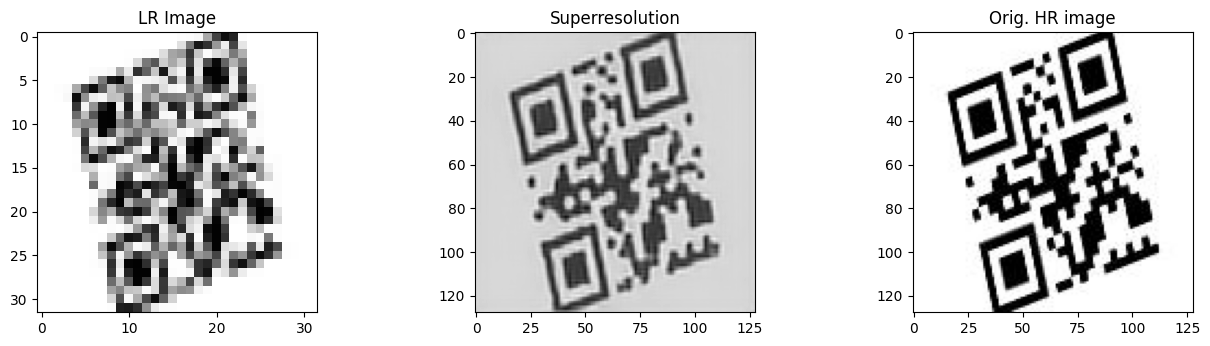

In [ ]:
from keras.models import load_model
from numpy.random import randint

[X1, X2] = [X_valid, y_valid]
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]
gen_image = generator.predict(src_image)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:], cmap = 'gray')
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(cv2.cvtColor(gen_image[0,:,:,:], cv2.COLOR_BGR2GRAY),cmap = 'gray')
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:], cmap = 'gray')

plt.show()